In [2]:
#Para posibles traducciones: 
#chunks = [tokens[x:x+250] for x in range(0, len(tokens), 100)] # split list into sublists of 250 words each
#translated = GoogleTranslator(source='auto', target='en').translate(chunks) --- NO funciona porque es muy grande
#ts._google.language_map

In [3]:
#!pip install deep-translator
#!pip install wordcloud

#Traductores
#!pip install deep_translator
#!pip install dl-translate
#!pip install translators --upgrade
#!pip install googletrans
#!pip install google_trans_new
!pip install langdetect

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 981 kB 5.3 MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993242 sha256=86b18bc9dd1749ffe8f2f9d90d0afc908bffdff536b5761313e261d48d735405
  Stored in directory: /root/.cache/pip/wheels/13/c7/b0/79f66658626032e78fc1a83103690ef6797d551cb22e56e734
Successfully built langdetect


In [33]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
import string
import re
import nltk
import gensim
import spacy
import en_core_web_sm
import requests

# Preprocesado y modelado
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import f1_score, accuracy_score
from sklearn import model_selection
from sklearn.cluster import MiniBatchKMeans

#nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk import pos_tag

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger') #<--- https://www.geeksforgeeks.org/python-lemmatization-approaches-with-examples/ 
nltk.download('punkt')

from bs4 import BeautifulSoup

# Configuración warnings
import warnings
warnings.filterwarnings('ignore')

#Translation
#from deep_translator import GoogleTranslator
#from googletrans import Translator
#from google_trans_new import google_translator
#from deep_translator import GoogleTranslator
from langdetect import detect
#import dl_translate as dlt
#import translators as ts

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
#Importamos el dataset completo
dftotal= pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Master/fapdaTesis.xlsx')
dftotal = dftotal.set_index('ID')

#Seleccionamos las columnas que nos servirán
dfsucio=dftotal.loc[:,['Title', 'Description', 'Additional information', 'CPP description' ,'Policy category code 1', 'Policy category code 2', 'Policy category code 3' ]]
dfsucio

Title  \
ID                                                                                                      
27                                                                                  Kenya Vision 2030   
33                                                  Segundo Plan Nacional de Seguridad Alimentaria...   
34                                                           National Nutrition Action Plan 2012-2017   
35                                                                                        Vision 2025   
36                                                      Plan Nacional de Restauración y Reforestación   
...                                                                                               ...   
4023                                                                National Irrigation Policy (2010)   
4024                                                Water Sector Development Programme (WSDP 2006 ...   
4025                                                              Community Development Policy (1996)   
NaN                                                                                               NaN   
Food and Agriculture Policy Framework Analysis ...                                                NaN   

                                                                                          Description  \
ID                                                                                                      
27                                                  Kenya Vision 2030 is the country’s long term d...   
33                                                  Fue aprobado el 2do Plan Nacional de Seguridad...   
34                                                  The Kenya National Nutrition Action Plan has b...   
35                                                  The Government of Pakistan (GoP) adopted a lon...   
36                                                  En el marco del Día Internacional de la Tierra...   
...                                                                                               ...   
4023                                                The main objective of the Policy is to have ir...   
4024                                                The WSDP comprises three components under the ...   
4025                                                The major objective of this Policy is to enabl...   
NaN                                                                                               NaN   
Food and Agriculture Policy Framework Analysis ...                                                NaN   

                                                                               Additional information  \
ID                                                                                                      
27                                                                                                NaN   
33                                                  El PlanSAN es el principal instrumento de plan...   
34                                                                                                NaN   
35                                                                                                NaN   
36                                                  Este Plan refuerza el compromiso asumido por E...   
...                                                                                               ...   
4023                                                                                              NaN   
4024                                                Improved water supply (65% rural and 90% urban...   
4025                                                                                              NaN   
NaN                                                                                               NaN   
Food and Agriculture Policy Framework Analysis ...                                                NaN   

In [6]:
#Renombramos columnas
dfs = dfsucio.rename(columns={'Additional information':'addinf',    'CPP description':'CPP'})
#Quitamos las dos ultimas filas, que no nos sirven
df = dfs.iloc[:-2]
#Quitamos los NaNs
df.fillna(' ',inplace=True)
df

Title  \
ID                                                        
27                                    Kenya Vision 2030   
33    Segundo Plan Nacional de Seguridad Alimentaria...   
34             National Nutrition Action Plan 2012-2017   
35                                          Vision 2025   
36        Plan Nacional de Restauración y Reforestación   
...                                                 ...   
4021  National Climate Change Response Strategy (202...   
4022        Human Settlements Development Policy (2000)   
4023                  National Irrigation Policy (2010)   
4024  Water Sector Development Programme (WSDP 2006 ...   
4025                Community Development Policy (1996)   

                                            Description  \
ID                                                        
27    Kenya Vision 2030 is the country’s long term d...   
33    Fue aprobado el 2do Plan Nacional de Seguridad...   
34    The Kenya National Nutrition Action Plan has b...   
35    The Government of Pakistan (GoP) adopted a lon...   
36    En el marco del Día Internacional de la Tierra...   
...                                                 ...   
4021  The overall objective of the NCCRS is therefor...   
4022  The goal of this policy is to facilitate equit...   
4023  The main objective of the Policy is to have ir...   
4024  The WSDP comprises three components under the ...   
4025  The major objective of this Policy is to enabl...   

                                                 addinf  \
ID                                                        
27                                                        
33    El PlanSAN es el principal instrumento de plan...   
34                                                        
35                                                        
36    Este Plan refuerza el compromiso asumido por E...   
...                                                 ...   
4021  The National Climate Change Response Strategy ...   
4022                                                      
4023                                                      
4024  Improved water supply (65% rural and 90% urban...   
4025                                                      

                                                    CPP  \
ID                                                        
27                                                        
33                                                        
34                                                        
35    The Government of Pakistan adopted Vision 2025...   
36                                                        
...                                                 ...   
4021                                                      
4022  The goal of this policy is to facilitate equit...   
4023                                                      
4024                                                      
4025                                                      

      Policy category code 1  Policy category code 2  Policy category code 3  
ID                                                                            
27                      11.0                     0.0                     0.0  
33                      21.0                     0.0                     0.0  
34                      22.0                     0.0                     0.0  
35                      11.0                     0.0                     0.0  
36                      52.0                     0.0                     0.0  
...                      ...                     ...                     ...  
4021                    55.0                     0.0                     0.0  
4022                    35.0                     0.0                     0.0  
4023                    32.0                     0.0                     0.0  
4024                    54.0                     0.0                     0.0  
4025                    13.0  

In [7]:
#Detectar idiomas y anadir columna con idioma
def det(x):
    try:
        lang = detect(x)
    except:
        lang = 'Other'
    return lang

df['Lang'] = df['Description'].apply(det)            

In [7]:
df

Title  \
ID                                                        
27                                    Kenya Vision 2030   
33    Segundo Plan Nacional de Seguridad Alimentaria...   
34             National Nutrition Action Plan 2012-2017   
35                                          Vision 2025   
36        Plan Nacional de Restauración y Reforestación   
...                                                 ...   
4021  National Climate Change Response Strategy (202...   
4022        Human Settlements Development Policy (2000)   
4023                  National Irrigation Policy (2010)   
4024  Water Sector Development Programme (WSDP 2006 ...   
4025                Community Development Policy (1996)   

                                            Description  \
ID                                                        
27    Kenya Vision 2030 is the country’s long term d...   
33    Fue aprobado el 2do Plan Nacional de Seguridad...   
34    The Kenya National Nutrition Action Plan has b...   
35    The Government of Pakistan (GoP) adopted a lon...   
36    En el marco del Día Internacional de la Tierra...   
...                                                 ...   
4021  The overall objective of the NCCRS is therefor...   
4022  The goal of this policy is to facilitate equit...   
4023  The main objective of the Policy is to have ir...   
4024  The WSDP comprises three components under the ...   
4025  The major objective of this Policy is to enabl...   

                                                 addinf  \
ID                                                        
27                                                        
33    El PlanSAN es el principal instrumento de plan...   
34                                                        
35                                                        
36    Este Plan refuerza el compromiso asumido por E...   
...                                                 ...   
4021  The National Climate Change Response Strategy ...   
4022                                                      
4023                                                      
4024  Improved water supply (65% rural and 90% urban...   
4025                                                      

                                                    CPP  \
ID                                                        
27                                                        
33                                                        
34                                                        
35    The Government of Pakistan adopted Vision 2025...   
36                                                        
...                                                 ...   
4021                                                      
4022  The goal of this policy is to facilitate equit...   
4023                                                      
4024                                                      
4025                                                      

      Policy category code 1  Policy category code 2  Policy category code 3  \
ID                                                                             
27                      11.0                     0.0                     0.0   
33                      21.0                     0.0                     0.0   
34                      22.0                     0.0                     0.0   
35                      11.0                     0.0                     0.0   
36                      52.0                     0.0                     0.0   
...                      ...                     ...                     ...   
4021                    55.0                     0.0                     0.0   
4022                    35.0                     0.0                     0.0   
4023                    32.0                     0.0                     0.0   
4024                    54.0                     0.0                     0.0   
4025              

In [8]:
dfen = df.loc[df['Lang'] == 'en']   #<----- resultados solo en ingles
dfen

Title  \
ID                                                        
27                                    Kenya Vision 2030   
34             National Nutrition Action Plan 2012-2017   
35                                          Vision 2025   
37             Kenya National Social Protection Policy    
39    Framework for the Implementation of Climate Ch...   
...                                                 ...   
4021  National Climate Change Response Strategy (202...   
4022        Human Settlements Development Policy (2000)   
4023                  National Irrigation Policy (2010)   
4024  Water Sector Development Programme (WSDP 2006 ...   
4025                Community Development Policy (1996)   

                                            Description  \
ID                                                        
27    Kenya Vision 2030 is the country’s long term d...   
34    The Kenya National Nutrition Action Plan has b...   
35    The Government of Pakistan (GoP) adopted a lon...   
37    The Kenya National Social Protection Policy (N...   
39    In view of Pakistan’s high vulnerability to th...   
...                                                 ...   
4021  The overall objective of the NCCRS is therefor...   
4022  The goal of this policy is to facilitate equit...   
4023  The main objective of the Policy is to have ir...   
4024  The WSDP comprises three components under the ...   
4025  The major objective of this Policy is to enabl...   

                                                 addinf  \
ID                                                        
27                                                        
34                                                        
35                                                        
37                                                        
39                                                        
...                                                 ...   
4021  The National Climate Change Response Strategy ...   
4022                                                      
4023                                                      
4024  Improved water supply (65% rural and 90% urban...   
4025                                                      

                                                    CPP  \
ID                                                        
27                                                        
34                                                        
35    The Government of Pakistan adopted Vision 2025...   
37                                                        
39    The Framework covered actions to address issue...   
...                                                 ...   
4021                                                      
4022  The goal of this policy is to facilitate equit...   
4023                                                      
4024                                                      
4025                                                      

      Policy category code 1  Policy category code 2  Policy category code 3  \
ID                                                                             
27                      11.0                     0.0                     0.0   
34                      22.0                     0.0                     0.0   
35                      11.0                     0.0                     0.0   
37                      41.0                     0.0                     0.0   
39                      55.0                     0.0                     0.0   
...                      ...                     ...                     ...   
4021                    55.0                     0.0                     0.0   
4022                    35.0                     0.0                     0.0   
4023                    32.0                     0.0                     0.0   
4024                    54.0                     0.0                     0.0   
4025              

In [9]:
#Unir todas las columnas con texto que nos interesan, ejemplo -----> users['full_name'] = users.last_name + ', ' + users.first_name
df['Texto'] = dfen.Title + ' ' + dfen.Description + ' ' + dfen.addinf + ' ' + dfen.CPP
dfen['Texto'] = dfen.Title + ' ' + dfen.Description + ' ' + dfen.addinf + ' ' + dfen.CPP
text = dfen['Texto'].values.tolist()

In [10]:
#trad = [ts.google(phrase, from_language='es', to_language='en') for phrase in text]

In [10]:
#Quitar mayusculas
textlower = [s.lower() for s in text]
textlower[0]

'kenya vision 2030 kenya vision 2030\xa0is the country’s long term development blueprint aimed at transforming kenya\xa0into a “newly industrializing, middle-income country providing a high quality of life to all its citizens by 2030”. it identifies agriculture as one of the key sectors to achieve an annual economic growth rate of 10 percent. under vision 2030, smallholder agriculture will be transformed from subsistence activities, marked by low productivity and value addition, to “an innovative, commercially-oriented, internationally competitive and modern agricultural sector”. vision 2030 is implemented through successive 5-year medium-term plans (mtps) which identify priorities in terms of policies, programmes and interventions. vision 2030 is based on three pillars: the economic, the social and the political. the adoption of vision 2030 comes after the successful implementation of the economic recovery strategy for wealth and employment creation (ers).    '

In [11]:
#quitar puntuacion
def remove_punc(string):
    punc = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
    for ele in string:  
        if ele in punc:  
            string = string.replace(ele, "") 
    return string
 
lis = [remove_punc(i) for i in textlower]
lis[0]

'kenya vision 2030 kenya vision 2030\xa0is the country’s long term development blueprint aimed at transforming kenya\xa0into a “newly industrializing middleincome country providing a high quality of life to all its citizens by 2030” it identifies agriculture as one of the key sectors to achieve an annual economic growth rate of 10 percent under vision 2030 smallholder agriculture will be transformed from subsistence activities marked by low productivity and value addition to “an innovative commerciallyoriented internationally competitive and modern agricultural sector” vision 2030 is implemented through successive 5year mediumterm plans mtps which identify priorities in terms of policies programmes and interventions vision 2030 is based on three pillars the economic the social and the political the adoption of vision 2030 comes after the successful implementation of the economic recovery strategy for wealth and employment creation ers    '

In [12]:
stop_words = set(stopwords.words('english'))

In [13]:
#limpieza otros caracteres y stopwords
corpus = dfen['Texto'].str.lower()\
          .str.replace('(@[a-z0-9]+)\w+',' ')\
          .str.replace('(http\S+)', ' ')\
          .str.replace('([^0-9a-z \t])',' ')\
        .str.replace('[0-9]+', ' ')\
          .str.replace(' +',' ')\
          .apply(lambda x: [i for i in x.split() if not i in stop_words])
print(corpus)

ID
27      [kenya, vision, kenya, vision, country, long, ...
34      [national, nutrition, action, plan, kenya, nat...
35      [vision, government, pakistan, gop, adopted, l...
37      [kenya, national, social, protection, policy, ...
39      [framework, implementation, climate, change, p...
                              ...                        
4021    [national, climate, change, response, strategy...
4022    [human, settlements, development, policy, goal...
4023    [national, irrigation, policy, main, objective...
4024    [water, sector, development, programme, wsdp, ...
4025    [community, development, policy, major, object...
Name: Texto, Length: 2635, dtype: object


In [14]:
counts = corpus.explode().value_counts()
counts_top = counts.nlargest(50)
counts_top

development       5556
national          4955
policy            3783
plan              3634
strategy          2996
sector            2397
sustainable       2160
health            2098
food              2096
management        2027
economic          1767
climate           1713
strategic         1695
resources         1584
objectives        1537
government        1508
implementation    1416
change            1404
agriculture       1361
services          1299
agricultural      1273
action            1260
framework         1221
social            1220
vision            1216
ensure            1215
water             1136
security          1130
nutrition         1124
country           1082
quality           1080
improve           1064
growth            1047
forest            1041
increase          1025
areas             1016
use                990
environment        989
production         988
support            962
promote            960
goal               949
access             880
public     

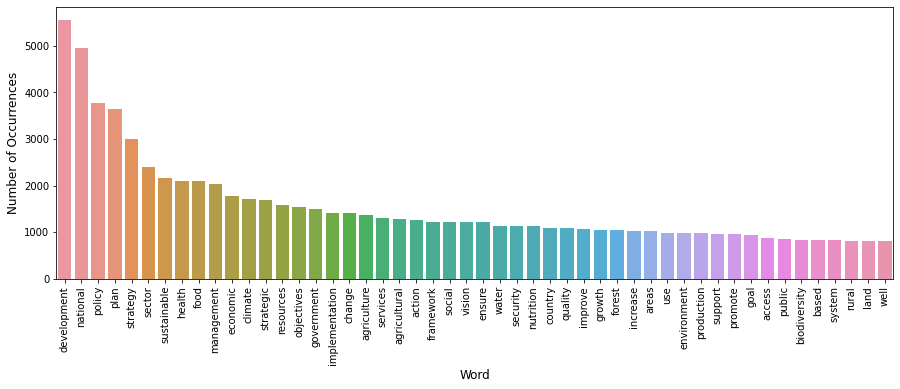

In [15]:
#Representar las palabas mas comunes
fig, ax = plt.subplots(figsize=(15,5))
sns.barplot(x=counts_top.index, y=counts_top.values, ax=ax)
ax.set_ylabel('Number of Occurrences', fontsize=12)
ax.set_xlabel('Word', fontsize=12)
ax.xaxis.set_tick_params(rotation=90)

In [25]:
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [16]:
#Ver numero de tokens que hay
from nltk.probability import FreqDist
allWords = []
for wordList in corpus:
    allWords += wordList
fdist = FreqDist(allWords)
print(fdist)
print(fdist.N())

<FreqDist with 12036 samples and 322592 outcomes>
322592


In [17]:
corpus_clean = dfen['Texto'].str.lower()\
          .str.replace('(@[a-z0-9]+)\w+',' ')\
          .str.replace('(http\S+)', ' ')\
          .str.replace('([^0-9a-z \t])',' ')\
        .str.replace('[0-9]+', ' ')\
          .str.replace(' +',' ').apply(lambda x: [i for i in x.split()])
corpus_clean

ID
27      [kenya, vision, kenya, vision, is, the, countr...
34      [national, nutrition, action, plan, the, kenya...
35      [vision, the, government, of, pakistan, gop, a...
37      [kenya, national, social, protection, policy, ...
39      [framework, for, the, implementation, of, clim...
                              ...                        
4021    [national, climate, change, response, strategy...
4022    [human, settlements, development, policy, the,...
4023    [national, irrigation, policy, the, main, obje...
4024    [water, sector, development, programme, wsdp, ...
4025    [community, development, policy, the, major, o...
Name: Texto, Length: 2635, dtype: object

In [18]:
#Pasar de series a dataframe
corpus_cleandf = corpus_clean.to_frame()
corpus_cleandf

Texto
ID                                                     
27    [kenya, vision, kenya, vision, is, the, countr...
34    [national, nutrition, action, plan, the, kenya...
35    [vision, the, government, of, pakistan, gop, a...
37    [kenya, national, social, protection, policy, ...
39    [framework, for, the, implementation, of, clim...
...                                                 ...
4021  [national, climate, change, response, strategy...
4022  [human, settlements, development, policy, the,...
4023  [national, irrigation, policy, the, main, obje...
4024  [water, sector, development, programme, wsdp, ...
4025  [community, development, policy, the, major, o...

[2635 rows x 1 columns]

In [19]:
corpus2a=corpus_cleandf['Texto']

In [27]:
lmtzr = WordNetLemmatizer()
corpus2lemm = corpus2a.apply(
                    lambda lst:[lmtzr.lemmatize(word,pos='v') for word in lst])
corpus2lemm

ID
27      [kenya, vision, kenya, vision, be, the, countr...
34      [national, nutrition, action, plan, the, kenya...
35      [vision, the, government, of, pakistan, gop, a...
37      [kenya, national, social, protection, policy, ...
39      [framework, for, the, implementation, of, clim...
                              ...                        
4021    [national, climate, change, response, strategy...
4022    [human, settlements, development, policy, the,...
4023    [national, irrigation, policy, the, main, obje...
4024    [water, sector, development, programme, wsdp, ...
4025    [community, development, policy, the, major, o...
Name: Texto, Length: 2635, dtype: object

In [28]:
additionalstopwords  = ['strategy','policy','plan', 'program', 'programme','action',
                        'goal','development','objective','strategic','objectives','sector','sustainable','country','implementation','national', #common words-transversal
                        'kenya', 'tanzania', 'pakistan', #countries
                        'adopt','enable','aim', #verbs
                        'percent','rate','well', 'million','low','usd','high','upper', 'low', 'middle','year','overall' , 'government',  'main', 'top', 'major',
                        'one', 'two', 'three','four','five','six','seven', 'eight','nine','ten']
swords = set().union(stopwords.words('english'),additionalstopwords)

In [29]:
#Quitar stopwords ---- Dataframelimpio=corpus2
corpus2 = corpus2lemm.apply(lambda words: [word for word in words if word not in swords])
corpus2df = corpus2.to_frame()
print(corpus2df) 

                                                  Texto
ID                                                     
27    [vision, vision, long, term, blueprint, transf...
34    [nutrition, nutrition, develop, operationalize...
35    [vision, gop, long, term, vision, transform, i...
37    [social, protection, social, protection, nspp,...
39    [framework, climate, change, view, vulnerabili...
...                                                 ...
4021  [climate, change, response, nccrs, therefore, ...
4022  [human, settlements, facilitate, equitable, sa...
4023  [irrigation, irrigation, systems, economically...
4024  [water, wsdp, wsdp, comprise, components, swap...
4025  [community, tanzanians, individuals, families,...

[2635 rows x 1 columns]


In [34]:
counts2 = corpus2.explode().value_counts()
counts_top2 = counts2.nlargest(50)
counts_top2

health          2098
food            2096
improve         2071
management      2027
increase        1818
economic        1767
ensure          1766
climate         1713
service         1633
resources       1584
change          1534
provide         1444
promote         1390
forest          1385
agriculture     1361
develop         1299
agricultural    1273
use             1241
framework       1221
social          1220
support         1219
vision          1216
include         1194
water           1168
security        1130
nutrition       1124
achieve         1122
strengthen      1115
quality         1080
reduce          1072
level           1062
growth          1047
areas           1016
environment      989
production       988
enhance          969
base             959
access           894
land             887
public           853
biodiversity     835
system           825
term             825
rural            821
energy           803
people           801
target           775
capacity     

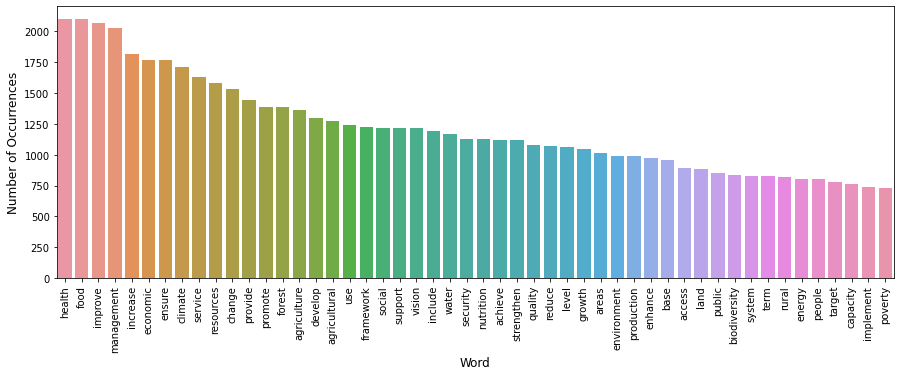

In [31]:
#Representar las palabas mas comunes
fig, ax = plt.subplots(figsize=(15,5))
sns.barplot(x=counts_top2.index, y=counts_top2.values, ax=ax)
ax.set_ylabel('Number of Occurrences', fontsize=12)
ax.set_xlabel('Word', fontsize=12)
ax.xaxis.set_tick_params(rotation=90)

In [35]:
corpus2postag = corpus2.apply(pos_tag)
print(corpus2postag)
print(corpus2postag[4025])

ID
27      [(vision, NN), (vision, NN), (long, JJ), (term...
34      [(nutrition, NN), (nutrition, NN), (develop, V...
35      [(vision, NN), (gop, NN), (long, JJ), (term, N...
37      [(social, JJ), (protection, NN), (social, JJ),...
39      [(framework, NN), (climate, NN), (change, NN),...
                              ...                        
4021    [(climate, NN), (change, NN), (response, NN), ...
4022    [(human, JJ), (settlements, NNS), (facilitate,...
4023    [(irrigation, NN), (irrigation, NN), (systems,...
4024    [(water, NN), (wsdp, NN), (wsdp, NN), (compris...
4025    [(community, NN), (tanzanians, NNS), (individu...
Name: Texto, Length: 2635, dtype: object
[('community', 'NN'), ('tanzanians', 'NNS'), ('individuals', 'NNS'), ('families', 'NNS'), ('group', 'NN'), ('associations', 'NNS'), ('contribute', 'VBP'), ('self', 'PRP'), ('reliance', 'NN'), ('therefore', 'RB'), ('bring', 'JJ'), ('level', 'NN'), ('finally', 'RB'), ('nation', 'NN'), ('whole', 'JJ'), ('address', 'NN')

In [36]:
#Extraer los verbos
verbs = []
for i in corpus2postag:
    temp = [j[0] for j in i if j[1].startswith("VB")]
    verbs.append(temp)

verbs = [item for sublist in verbs for item in sublist]
verbss = pd.Series(verbs)
verbssnum = verbss.explode().value_counts()
verbssnum = verbssnum.nlargest(50)
verbssnum

improve          1941
ensure           1766
include          1155
develop          1148
reduce           1072
provide          1047
achieve           917
promote           580
set               551
make              488
build             448
strengthen        445
establish         433
increase          427
identify          360
need              310
take              289
follow            261
protect           236
create            228
approve           185
use               184
contribute        170
expect            169
mainstreaming     168
ecosystems        168
climate           163
focus             162
relate            158
exist             153
integrate         150
enhance           148
require           143
continue          140
live              137
maintain          133
involve           130
produce           127
support           121
maize             117
target            111
give              109
serve             107
level             107
expand            105
land      

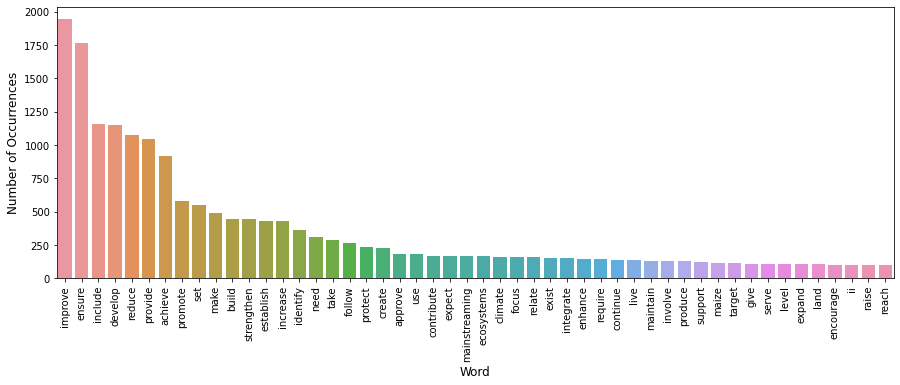

In [37]:
#Representar las palabas mas comunes
fig, ax = plt.subplots(figsize=(15,5))
sns.barplot(x=verbssnum.index, y=verbssnum.values, ax=ax)
ax.set_ylabel('Number of Occurrences', fontsize=12)
ax.set_xlabel('Word', fontsize=12)
ax.xaxis.set_tick_params(rotation=90)

In [38]:
verbs_todelete= ['improve','ensure', 'include', 'develop' ,'reduce', 'provide', 'achieve', 'promote', 'set', 'make','build', 'strengthen', 'establish', 'increase', 'identify', 'need' ,'take', 'follow', 'protect', 'create', 'approve', 'use', 'expect', 'contribute', 'mainstreaming','focus', 'relate', 'exist', 'integrate', 'require', 'enhance', 'continue', 'live', 'maintain', 'adopt', 'involve', 'support', 'produce', 'give', 'target', 'level', 'expand', 'serve', 'encourage', 'ii', 'reach', 'access', 'implement']

In [39]:
swords2 = set().union(swords,verbs_todelete)
print(swords2)

{'create', 'require', 'those', 'build', 'ten', 'serve', "you'll", "you'd", 'ourselves', 'myself', 'below', 'off', 'here', 'achieve', 'be', 'against', 'so', 'me', 'too', 'on', 'improve', 'reach', 'once', 'should', 'any', 'middle', 'because', 'over', 'ensure', 'was', 'no', 'adopt', 'the', "wouldn't", 'major', "isn't", 'weren', 'it', 'include', 're', 'after', 'does', 'by', 'hasn', 'strategic', 'target', "couldn't", 'percent', 'programme', 's', 'who', 'follow', 'up', 'six', 'such', 'live', 'support', 'most', 'rate', 'to', 'mightn', 'encourage', "needn't", 'policy', 'two', 'but', "should've", 'increase', 'about', 'm', 'implement', 'exist', 't', 'sector', 'now', 'national', 'a', 'ma', 'where', "shan't", 'wasn', 'wouldn', 'development', 'develop', "you're", 'both', 'each', 'four', 'make', 'he', 'aren', 'upper', 'she', 'herself', 'hadn', 'plan', 'few', 'with', 'some', "she's", 'and', "didn't", 'top', 'ii', 'implementation', 'maintain', 'this', 'set', 'access', 'which', 'his', 'there', "mustn't

In [40]:
corpus3 = corpus2lemm.apply(lambda words: [word for word in words if word not in swords2])
corpus3df = corpus3.to_frame()
print(corpus3df)

                                                  Texto
ID                                                     
27    [vision, vision, long, term, blueprint, transf...
34    [nutrition, nutrition, operationalize, strateg...
35    [vision, gop, long, term, vision, transform, i...
37    [social, protection, social, protection, nspp,...
39    [framework, climate, change, view, vulnerabili...
...                                                 ...
4021  [climate, change, response, nccrs, therefore, ...
4022  [human, settlements, facilitate, equitable, sa...
4023  [irrigation, irrigation, systems, economically...
4024  [water, wsdp, wsdp, comprise, components, swap...
4025  [community, tanzanians, individuals, families,...

[2635 rows x 1 columns]


In [41]:
counts3 = corpus3.explode().value_counts()
counts_top3 = counts3.nlargest(50)
counts_top3

health           2098
food             2096
management       2027
economic         1767
climate          1713
service          1633
resources        1584
change           1534
forest           1385
agriculture      1361
agricultural     1273
framework        1221
social           1220
vision           1216
water            1168
security         1130
nutrition        1124
quality          1080
growth           1047
areas            1016
environment       989
production        988
base              959
land              887
public            853
biodiversity      835
term              825
system            825
rural             821
energy            803
people            801
capacity          764
poverty           731
goals             727
natural           716
women             711
environmental     707
effective         702
state             700
education         695
market            689
protection        677
value             677
human             663
gender            649
risk      

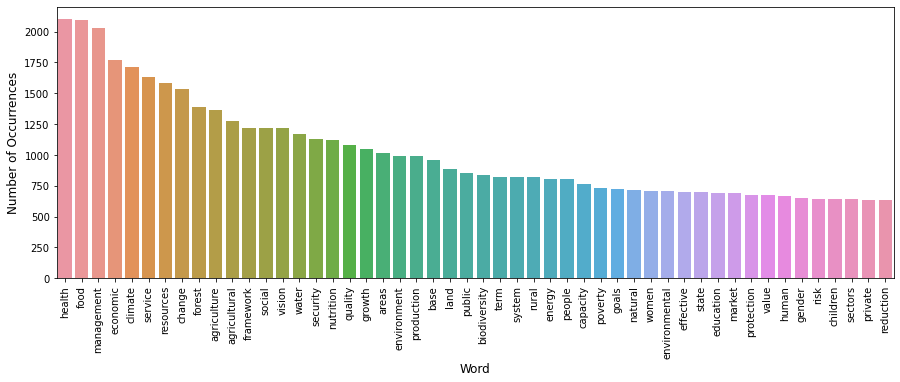

In [42]:
#Representar las palabas mas comunes
fig, ax = plt.subplots(figsize=(15,5))
sns.barplot(x=counts_top3.index, y=counts_top3.values, ax=ax)
ax.set_ylabel('Number of Occurrences', fontsize=12)
ax.set_xlabel('Word', fontsize=12)
ax.xaxis.set_tick_params(rotation=90)

In [48]:
dfen['tokenclean']=corpus3
dfen['Policycat']=dfen['Policy category code 1'].astype(str)
dfen['corpus3'] = [' '.join(map(str, l)) for l in dfen['tokenclean']]
dfen.dtypes

Title                      object
Description                object
addinf                     object
CPP                        object
Policy category code 1    float64
Policy category code 2    float64
Policy category code 3    float64
Lang                       object
Texto                      object
tokenclean                 object
Policycat                  object
corpus3                    object
dtype: object

In [49]:
dfen

Title  \
ID                                                        
27                                    Kenya Vision 2030   
34             National Nutrition Action Plan 2012-2017   
35                                          Vision 2025   
37             Kenya National Social Protection Policy    
39    Framework for the Implementation of Climate Ch...   
...                                                 ...   
4021  National Climate Change Response Strategy (202...   
4022        Human Settlements Development Policy (2000)   
4023                  National Irrigation Policy (2010)   
4024  Water Sector Development Programme (WSDP 2006 ...   
4025                Community Development Policy (1996)   

                                            Description  \
ID                                                        
27    Kenya Vision 2030 is the country’s long term d...   
34    The Kenya National Nutrition Action Plan has b...   
35    The Government of Pakistan (GoP) adopted a lon...   
37    The Kenya National Social Protection Policy (N...   
39    In view of Pakistan’s high vulnerability to th...   
...                                                 ...   
4021  The overall objective of the NCCRS is therefor...   
4022  The goal of this policy is to facilitate equit...   
4023  The main objective of the Policy is to have ir...   
4024  The WSDP comprises three components under the ...   
4025  The major objective of this Policy is to enabl...   

                                                 addinf  \
ID                                                        
27                                                        
34                                                        
35                                                        
37                                                        
39                                                        
...                                                 ...   
4021  The National Climate Change Response Strategy ...   
4022                                                      
4023                                                      
4024  Improved water supply (65% rural and 90% urban...   
4025                                                      

                                                    CPP  \
ID                                                        
27                                                        
34                                                        
35    The Government of Pakistan adopted Vision 2025...   
37                                                        
39    The Framework covered actions to address issue...   
...                                                 ...   
4021                                                      
4022  The goal of this policy is to facilitate equit...   
4023                                                      
4024                                                      
4025                                                      

      Policy category code 1  Policy category code 2  Policy category code 3  \
ID                                                                             
27                      11.0                     0.0                     0.0   
34                      22.0                     0.0                     0.0   
35                      11.0                     0.0                     0.0   
37                      41.0                     0.0                     0.0   
39                      55.0                     0.0                     0.0   
...                      ...                     ...                     ...   
4021                    55.0                     0.0                     0.0   
4022                    35.0                     0.0                     0.0   
4023                    32.0                     0.0                     0.0   
4024                    54.0                     0.0                     0.0   
4025              

In [50]:
from google.colab import files
df.to_csv('dfenclean.csv') 
files.download('dfenclean.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>